In [1]:
import warnings
warnings.filterwarnings("ignore")

### MODEL DEVELOPMENT

In [2]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
#Read in cleaned 2019 and 2021 Dataframes with numerical outliers removed
model_train = pd.read_csv('mydata/MMSA2019_Cleaned_2.csv')
model_valid = pd.read_csv('mydata/MMSA2021_Cleaned_2.csv')

In [5]:
model_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83666 entries, 0 to 83665
Data columns (total 97 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DISPCODE  83666 non-null  int64  
 1   HHADULT   83666 non-null  float64
 2   SEXVAR    83666 non-null  object 
 3   GENHLTH   83666 non-null  object 
 4   PHYSHLTH  83666 non-null  float64
 5   MENTHLTH  83666 non-null  float64
 6   _HLTHPLN  83666 non-null  object 
 7   MEDCOST1  83666 non-null  object 
 8   CHECKUP1  83666 non-null  object 
 9   CVDINFR4  83666 non-null  object 
 10  CVDCRHD4  83666 non-null  object 
 11  CVDSTRK3  83666 non-null  object 
 12  ASTHMA3   83666 non-null  object 
 13  CHCSCNCR  83666 non-null  object 
 14  CHCOCNCR  83666 non-null  object 
 15  ADDEPEV3  83666 non-null  object 
 16  CHCKDNY2  83666 non-null  object 
 17  DIABETE4  83666 non-null  object 
 18  MARITAL   83666 non-null  object 
 19  EDUCA     83666 non-null  object 
 20  RENTHOM1  83666 non-null  ob

In [6]:
model_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104619 entries, 0 to 104618
Data columns (total 97 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DISPCODE  104619 non-null  int64  
 1   HHADULT   104619 non-null  float64
 2   SEXVAR    104619 non-null  object 
 3   GENHLTH   104619 non-null  object 
 4   PHYSHLTH  104619 non-null  float64
 5   MENTHLTH  104619 non-null  float64
 6   _HLTHPLN  104619 non-null  object 
 7   MEDCOST1  104619 non-null  object 
 8   CHECKUP1  104619 non-null  object 
 9   CVDINFR4  104619 non-null  object 
 10  CVDCRHD4  104619 non-null  object 
 11  CVDSTRK3  104619 non-null  object 
 12  ASTHMA3   104619 non-null  object 
 13  CHCSCNCR  104619 non-null  object 
 14  CHCOCNCR  104619 non-null  object 
 15  ADDEPEV3  104619 non-null  object 
 16  CHCKDNY2  104619 non-null  object 
 17  DIABETE4  104619 non-null  object 
 18  MARITAL   104619 non-null  object 
 19  EDUCA     104619 non-null  object 
 20  RENT

<Axes: xlabel='_RFHLTH', ylabel='count'>

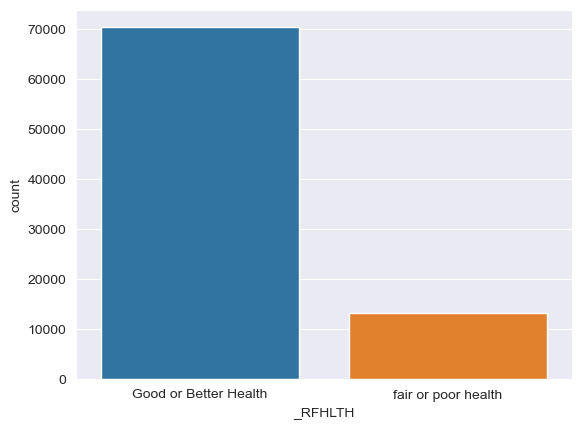

In [7]:
#Balance of the Dataset 
sns.set_style('darkgrid')
sns.countplot(x=model_train['_RFHLTH'])

We can see that the ratio of those who percieve their health to be good vs those who do not is 7:1 an indication of a highly imbalanced Dataset. We can apply SMOTE technique to introduced randomn samples of the lower class in order to balance out the samples for model training.

In [8]:
model_train['_RFHLTH'].value_counts()

_RFHLTH
Good or Better Health    70370
fair or poor health      13296
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_predict,StratifiedKFold,GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,confusion_matrix

In [10]:
#lets create a new data frame with only dummmy categorical data and num columns 
num_cols = list(model_train.select_dtypes(exclude='object').columns)
cat_cols = list(model_train.select_dtypes(include='object').columns)

dummies_df = model_train[num_cols]
cat_cols = list(cat_cols)

for i in ['GENHLTH','_RFHLTH']:
    cat_cols.remove(i)


for i in cat_cols:
    temp = pd.get_dummies(model_train[i],drop_first=True,prefix=i)
    dummies_df = pd.concat([dummies_df,temp],axis=1)

dummies_df.head()

,DISPCODE,HHADULT,PHYSHLTH,MENTHLTH,CPDEMO1B,CHILDREN,WEIGHT2,HEIGHT3,_STSTR,_PHYS14D,...,STATE_South Carolina,STATE_South Dakota,STATE_Tennessee,STATE_Texas,STATE_Utah,STATE_Vermont,STATE_Virginia,STATE_Washington,STATE_West Virginia,STATE_Wisconsin
0,1200,2.0,0.0,0.0,2.0,3.0,180.0,1.7780,16049,1,...,False,True,False,False,False,False,False,False,False,False
1,1200,3.0,20.0,0.0,1.0,0.0,265.0,1.8034,16049,3,...,False,True,False,False,False,False,False,False,False,False
2,1200,1.0,1.0,0.0,1.0,0.0,170.0,1.7272,16049,2,...,False,True,False,False,False,False,False,False,False,False
3,1100,2.0,0.0,0.0,1.0,4.0,280.0,1.8288,16039,1,...,False,True,False,False,False,False,False,False,False,False
4,1100,2.0,0.0,0.0,1.0,0.0,270.0,1.9304,16049,1,...,False,True,False,False,False,False,False,False,False,False


In [11]:
dummies_df.columns = dummies_df.columns.astype(str)
model_train.columns = model_train.columns.astype(str)

In [12]:
# Your 2019 dataset
X = dummies_df
y = model_train['_RFHLTH']

**BASE MODELS**

In [16]:
#Base Decision tree without gridsearch or smote

# Initialize the Decision Tree Classifier
dtree = DecisionTreeClassifier(random_state=42)

# Setup cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
# This will give you out-of-sample predictions for each part of your data
predictions = cross_val_predict(dtree, X, y, cv=stratified_kfold)

# Print classification report and confusion matrix
print(classification_report(y, predictions))
print('---------------------------------------')
print(confusion_matrix(y, predictions))


                       precision    recall  f1-score   support

Good or Better Health       0.90      0.90      0.90     70370
  fair or poor health       0.48      0.50      0.49     13296

             accuracy                           0.84     83666
            macro avg       0.69      0.70      0.70     83666
         weighted avg       0.84      0.84      0.84     83666

---------------------------------------
[[63298  7072]
 [ 6659  6637]]


In [17]:
#Base Decision with gridsearch

# Decision tree classifier
dtree = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    # Add other parameters here if you want
}

# Setup cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Setup grid search
grid_search = GridSearchCV(dtree, param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search.fit(X, y)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Predictions with the best estimator
best_dtree = grid_search.best_estimator_
predictions = best_dtree.predict(X)

# Print classification report and confusion matrix
print(classification_report(y, predictions))
print('---------------------------------------')
print(confusion_matrix(y, predictions))


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.8781703377745529
                       precision    recall  f1-score   support

Good or Better Health       0.92      0.97      0.95     70370
  fair or poor health       0.81      0.57      0.67     13296

             accuracy                           0.91     83666
            macro avg       0.86      0.77      0.81     83666
         weighted avg       0.90      0.91      0.90     83666

---------------------------------------
[[68522  1848]
 [ 5654  7642]]


In [18]:
#Base Decision tree with gridsearch and Smote

from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

# 2. Setting up the pipeline with SMOTE and Decision Tree
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameters for grid search (just an example, you might want to adjust or add more parameters)
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10]
}

# 3. Performing cross-validation and grid search
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',  # you can adjust this
                           cv=stratified_kfold,
                           n_jobs=-1)

# This will give you out-of-sample predictions for each part of your data
predictions = cross_val_predict(grid_search, X, y, cv=stratified_kfold)

# Print classification report and confusion matrix
print(classification_report(y, predictions))
print('---------------------------------------')
print(confusion_matrix(y, predictions))

# If you want to train the best model found during the grid search on the entire dataset:
# grid_search.fit(X, y)


                       precision    recall  f1-score   support

Good or Better Health       0.92      0.93      0.93     70370
  fair or poor health       0.61      0.56      0.59     13296

             accuracy                           0.87     83666
            macro avg       0.76      0.75      0.76     83666
         weighted avg       0.87      0.87      0.87     83666

---------------------------------------
[[65598  4772]
 [ 5826  7470]]


1) Logistic Regression without SMOTE or Grid Search

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)

# 5-fold Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5)

# Placeholder for classification reports
reports = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    reports.append(report)

# Displaying each fold's classification report
for i, report in enumerate(reports, 1):
    print(f"Fold {i} Classification Report:\n{report}\n")

2) Logistic Regression with Grid Search

In [ ]:
# Logistic Regression with GridSearchCV
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['newton-cg', 'lbfgs', 'liblinear']}
logreg = LogisticRegression(max_iter=1000)
clf = GridSearchCV(logreg, parameters, cv=5)

clf.fit(X, y)

# Best parameters and best score
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)

# Classification report on test data
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


3) Logistic Regression with SMOTE and Grid Search

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Creating a pipeline with SMOTE and Logistic Regression
pipeline = Pipeline([
    ('smote', SMOTE()),
    ('logreg', LogisticRegression(max_iter=1000))
])

clf = GridSearchCV(pipeline, parameters, cv=5)
clf.fit(X, y)

# Best parameters and best score
print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)

# Classification report on test data
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# Once the best model is selected, use it to make predictions on the 2021 dataset
# Assuming X_2021 and y_2021 are your 2021 dataset
# test_score = roc_auc_score(y_2021, grid_search.predict(X_2021))
# print(f'Test score on 2021 data: {test_score}')

In [ ]:
#Running Cross Validation on base Decision tree with SMOTE




In [ ]:
#Naive Bayes Using all features

In [ ]:
#RandomForestClassifier Using all features

In [ ]:
#Applying SMOTE To the dataset 

### Can perceived health be accurately predicted using dietary habits, socioeconomic indicators, lifestyle choices, and individual metrics?